## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization ,Dense 
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer  = keras.layers.Input(input_shape)
    for i ,n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units , activation = "relu" , name = "hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else :
            x = Dense(units = n_units , activation = "relu", name = "hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    out = Dense(units = output_units , activation = "softmax" , name = "output_layer")(x)
    model = keras.models.Model(inputs=[input_layer],outputs = [out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [12]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


def combined_loss(ce_weight,gamma=2.,alpha=4.):
    """Define the customized loss."""
    gamma  = float(gamma)
    alpha  = float(alpha)
    def combined_loss_fixed(y_true,y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl*(1-ce_weight)+ce*ce_weight, axis=1)
        return tf.reduce_mean(reduced_fl)
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [16]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss = combined_loss(ce_weight = ce_w), metrics=["accuracy"] , optimizer = optimizer )
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128) 

50000/50000 [==============================] - 2s 44us/step - loss: 2.3407 - acc: 0.6006 - val_loss: 3.2177 - val_acc: 0.4777
Epoch 11/25
50000/50000 [==============================] - 2s 45us/step - loss: 2.2394 - acc: 0.6151 - val_loss: 3.2670 - val_acc: 0.4752
Epoch 12/25
50000/50000 [==============================] - 2s 43us/step - loss: 2.1428 - acc: 0.6304 - val_loss: 3.1517 - val_acc: 0.4895
Epoch 13/25
50000/50000 [==============================] - 2s 43us/step - loss: 2.0433 - acc: 0.6447 - val_loss: 3.2115 - val_acc: 0.4806
Epoch 14/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.9573 - acc: 0.6578 - val_loss: 3.2006 - val_acc: 0.4853
Epoch 15/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.8734 - acc: 0.6697 - val_loss: 3.2768 - val_acc: 0.4817
Epoch 16/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7827 - acc: 0.6828 - val_loss: 3.5334 - val_acc: 0.4512
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.4034 - acc: 0.3053 - val_loss: 3.5167 - val_acc: 0.3263
Epoch 2/25
50000/50000 [==============================] - 2s 43us/step - loss: 2.5516 - acc: 0.4221 - val_loss: 2.8005 - val_acc: 0.3994
Epoch 3/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.3393 - acc: 0.4649 - val_loss: 2.5584 - val_acc: 0.4236
Epoch 4/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.2161 - acc: 0.4892 - val_loss: 2.5082 - val_acc: 0.4367
Epoch 5/25
50000/50000 [==============================] - 2s 43us/step - loss: 2.1178 - acc: 0.5087 - val_loss: 2.3879 - val_acc: 0.4541
Epoch 6/25
50000/50000 [==============================] - 2s 43us/step - loss: 2.0364 - acc: 0.5244 - val_loss: 2.2916 - val_acc: 0.4656
Epoch 7/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.9632 - acc: 0.5415 - val_loss: 2.3011 - val_acc

50000/50000 [==============================] - 2s 40us/step - loss: 0.9735 - acc: 0.6710 - val_loss: 1.4461 - val_acc: 0.4912
Epoch 25/25
50000/50000 [==============================] - 2s 42us/step - loss: 0.9533 - acc: 0.6755 - val_loss: 1.4713 - val_acc: 0.4917


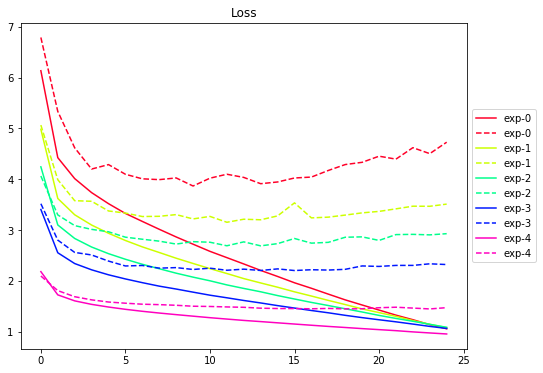

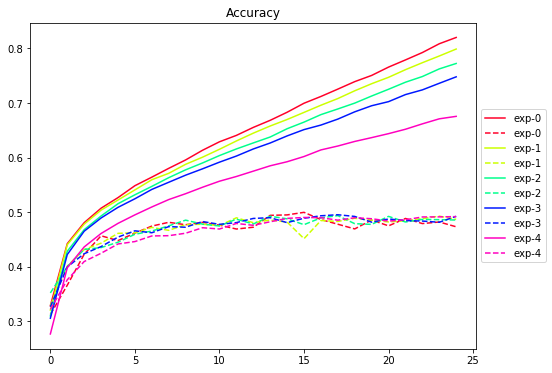

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()